In [ ]:
!pip3 install fastai torch torchvision fastbook

In [11]:
import os
from pprint import pprint
import requests

In [12]:
bing_api_key = "1ef8e281347a435c9ccccd1848419317"

In [54]:
def image_search(api_key, query, num_imgs=100):
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    params = {"q": query, "count": num_imgs}
    response = requests.get(
        "https://api.cognitive.microsoft.com/bing/v7.0/images/search",
        headers=headers,
        params=params
    )
    return response.json()

In [91]:
def download_img(url, img_path):
    try:
        img_response = requests.get(url)
    except Exception as e:
        print(f"Failed to get image from {url}: {str(e)}")
        return
    
    file = open(img_path, "wb+")
    file.write(img_response.content)
    file.close()

In [106]:
def get_bear_imgs(bear_types):
    for bear_type in bear_types:
        new_bear_type_dir = os.path.join(os.getcwd(), "bears", bear_type)
        os.makedirs(new_bear_type_dir, exist_ok=True)
        bear_img_response = image_search(bing_api_key, f"{bear_type} bear")
        bear_img_urls = [bear_img["contentUrl"] for bear_img in bear_img_response["value"]]

        i = 0
        for bear_img_url in bear_img_urls:
            bear_filename = os.path.join(new_bear_type_dir, f"{bear_type}_bear_{i}.png")
            download_img(bear_img_url, bear_filename)
            i += 1

In [107]:
bear_types = ["grizzly", "black", "teddy"]
get_bear_imgs(bear_types)

Failed to get image from https://assets.vancouverisawesome.com/wp-content/uploads/2018/07/08143100/grizzly-bear.jpg: HTTPSConnectionPool(host='assets.vancouverisawesome.com', port=443): Max retries exceeded with url: /wp-content/uploads/2018/07/08143100/grizzly-bear.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f6950710f28>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Failed to get image from https://assets.vancouverisawesome.com/wp-content/uploads/2017/12/18131050/grizzly-bears.jpg: HTTPSConnectionPool(host='assets.vancouverisawesome.com', port=443): Max retries exceeded with url: /wp-content/uploads/2017/12/18131050/grizzly-bears.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f6950710da0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Failed to get image from https://media.mnn.com/assets/images/2016/06/american-black-bear.jpg.838

In [113]:
fns = get_image_files("bears")
failed = verify_images(fns)
for failed_img in failed:
    os.remove(failed_img) 

In [115]:
from fastai.vision.widgets import *
import fastbook
fastbook.setup_book()
from fastbook import *

bears_path = "bears"

In [103]:
bears = DataBlock(
    # Form of input and label data
    blocks=(ImageBlock, CategoryBlock), 
    # How to read data
    get_items=get_image_files, 
    # Split into training and validation data
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Get parent dir of image to get label (e.g. bears/black/black_bear_1.png)
    get_y=parent_label,
    # Resize each image to 128x128
    item_tfms=Resize(128)
)

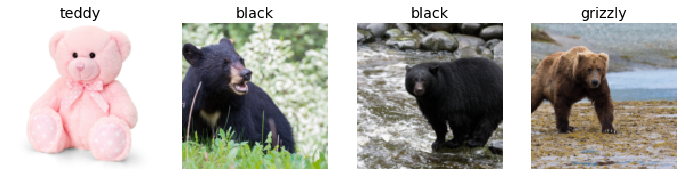

In [114]:
dls = bears.dataloaders(bears_path)
dls.valid.show_batch(max_n=4, nrows=1)

In [116]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(bears_path)

In [117]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nrs/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.046028,1.821525,0.407407,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.422580,0.365254,0.203704,00:14
1,0.330775,0.025298,0.000000,00:14
2,0.260102,0.015738,0.000000,00:14
3,0.200037,0.020921,0.018519,00:14


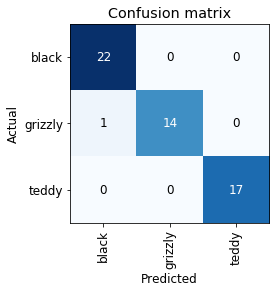

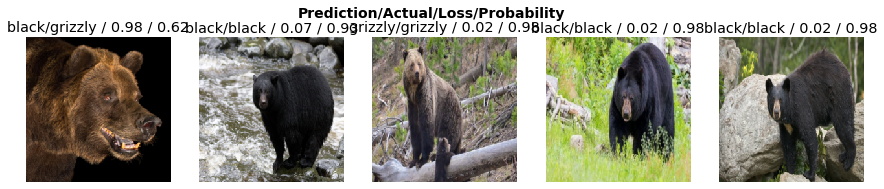

In [118]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [126]:
learn.export()
learn_inf = load_learner("export.pkl")
learn_inf.predict("bears/teddy/teddy_bear_0.png")

('teddy', tensor(2), tensor([5.6529e-08, 3.0980e-08, 1.0000e+00]))